In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

In [26]:
data = pd.read_csv("C:/Users/Akif/Desktop/football/rankingv1.csv")

In [27]:
data.shape

(2691, 40)

In [28]:
selected_columns = [
    'home_club_id', 'away_club_id', 'attendance', 'result', 'home_team_points', 'away_team_points',
       'home_attack_value', 'away_attack_value',
        'home_midfield_value',
       'away_midfield_value',  'home_defender_value',
       'away_defender_value', 
       'home_goalkeeper_value',
       'away_goalkeeper_value', 
       'home_total_market_value', 'away_total_market_value',
       'home_power_score', 'away_power_score'
]
data = data[selected_columns]


In [29]:
result_counts = data['result'].value_counts()
print("Class distribution in 'result' column:")
print(result_counts)

Class distribution in 'result' column:
1    1223
2     772
0     696
Name: result, dtype: int64


In [30]:
X = data.drop('result', axis=1)
y = data['result']

scaler = StandardScaler()
X = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

In [31]:
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Akif\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3567 - loss: 1.8129 - val_accuracy: 0.4294 - val_loss: 1.0739
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3765 - loss: 1.6960 - val_accuracy: 0.4458 - val_loss: 1.0925
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3987 - loss: 1.7195 - val_accuracy: 0.4636 - val_loss: 1.0937
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3843 - loss: 1.6594 - val_accuracy: 0.4829 - val_loss: 1.0953
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3993 - loss: 1.6325 - val_accuracy: 0.4948 - val_loss: 1.1007
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4062 - loss: 1.6150 - val_accuracy: 0.4993 - val_loss: 1.0986
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4243 - loss: 1.5197 - val_accuracy: 0.5037 - val_loss: 1.0959
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3954 - loss: 1.5879 - val_accuracy: 0.4993 - val_loss:

In [34]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [35]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       177
           1       0.53      0.85      0.65       297
           2       0.52      0.53      0.53       199

    accuracy                           0.53       673
   macro avg       0.35      0.46      0.39       673
weighted avg       0.39      0.53      0.45       673



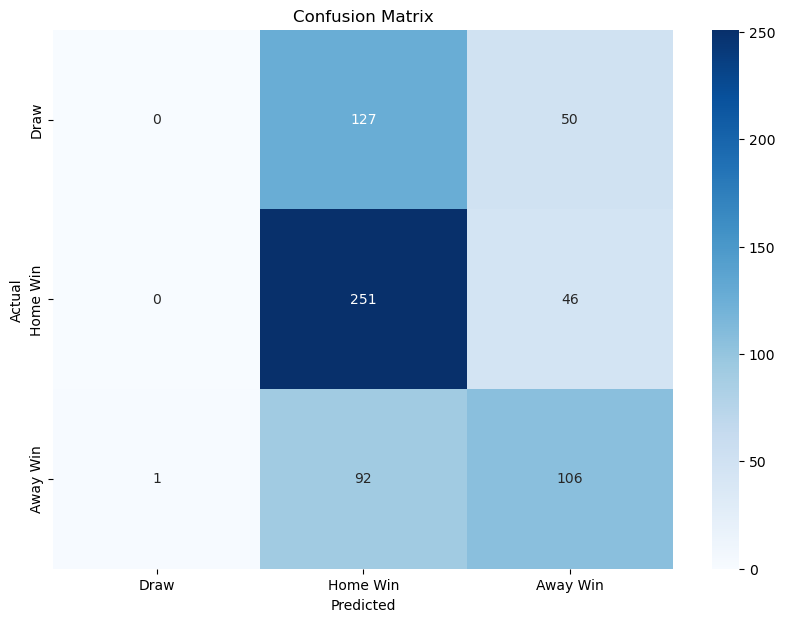

In [36]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Draw', 'Home Win', 'Away Win'], yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
def get_team_stats(team_id, data):
    team_data = data[(data['home_club_id'] == team_id) | (data['away_club_id'] == team_id)]
    team_avg_stats = team_data.mean()
    return team_avg_stats.drop(['home_club_id', 'away_club_id', 'result'])

In [25]:
def predict_match(model, home_team_id, away_team_id, scaler, data):
    home_stats = get_team_stats(home_team_id, data)
    away_stats = get_team_stats(away_team_id, data)
    
    combined_stats = np.concatenate((home_stats, away_stats))

    feature_columns = data.columns.drop(['home_club_id', 'away_club_id', 'result'])
    combined_stats_df = pd.DataFrame([combined_stats], columns=list(feature_columns) + list(feature_columns))

    combined_stats = scaler.transform(combined_stats_df.values)

    prediction = model.predict(combined_stats)
    return prediction

In [26]:
home_team_id = 3008
away_team_id = 148
prediction = predict_match(model, home_team_id, away_team_id, scaler, data)
print(f'Prediction: {prediction}')

C:\Users\Akif\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required by StandardScaler.

In [89]:
def predict_match(model, match_features, scaler):
    
    match_features_scaled = scaler.transform(match_features)
    prediction = model.predict(match_features_scaled)
    return prediction

new_match_features = pd.DataFrame([{
    'home_club_id': 3008,
    'away_club_id': 148,
    'attendance': 50000,
    'home_team_points': 65,
    'away_team_points': 70,
    'home_attack_value': 75,
    'home_attack_count': 100,
    'away_attack_value': 80,
    'away_attack_count': 110,
    'home_midfield_value': 70,
    'home_midfield_count': 95,
    'away_midfield_value': 72,
    'away_midfield_count': 90,
    'home_defender_value': 78,
    'home_defender_count': 110,
    'away_defender_value': 75,
    'away_defender_count': 100,
    'home_goalkeeper_value': 80,
    'home_goalkeeper_count': 30,
    'away_goalkeeper_value': 78,
    'away_goalkeeper_count': 35,
    'home_total_market_value': 300000000,
    'away_total_market_value': 250000000,
    'home_power_score': 78,
    'away_power_score': 80
}])

prediction = predict_match(model, new_match_features, scaler)
print(f'Prediction: {prediction}')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- away_attack_count
- away_defender_count
- away_goalkeeper_count
- away_midfield_count
- home_attack_count
- ...


In [90]:
def predict_match(model, match_features, scaler):
    
    match_features_scaled = scaler.transform(match_features)
    prediction = model.predict(match_features_scaled)
    return prediction

new_match_features = pd.DataFrame([{
    'home_club_id': 3008,
    'away_club_id': 148,
    'attendance': 50000,
    'home_team_points': 65,
    'away_team_points': 70,
    'home_attack_value': 75,
    'away_attack_value': 80,
    'home_midfield_value': 70,
    'away_midfield_value': 72,
    'home_defender_value': 78,
    'away_defender_value': 75,
    'home_goalkeeper_value': 80,
    'away_goalkeeper_value': 78,
    'home_total_market_value': 300000000,
    'away_total_market_value': 250000000,
    'home_power_score': 78,
    'away_power_score': 80
}])

prediction = predict_match(model, new_match_features, scaler)
print(f'Prediction: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: [[0. 0. 1.]]
